In [1]:
import pandas as pd
import numpy as np
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt




In [2]:
# 生成标签值：下一天收盘价（涉及删除最后一条数据，不要重复执行该函数）
def generate_label(data_path):
    df = pd.read_csv(data_path)

    for i in ['xa','ya','za','row','pitch','yaw']:
        next_close = list()
        for j in range(len(df[i])-1):
            next_close.append(df[i][j+1])
        next_close.append(0)
        df['new'+i] = next_close
    df.to_csv('new_UAV.csv',index=None)

# 生成训练和测试数据
def generate_model_data(data_path, alpha, seq_len):
    Mean = dict()
    Std = dict()
    data_path = 'new_UAV.csv'
    df = pd.read_csv(data_path)
    train_seq = int((len(df) - seq_len + 1))
    cnt = 0
    for property in ['xa','ya','za','row','pitch','yaw','newxa','newya','newza','newrow','newpitch','newyaw']:
        df[property] = np.reshape(np.array(df[property]), (-1, 1))
        Mean[cnt] = df[property].mean() 
        Std[cnt] = df[property].std()
        df[property] = (df[property]-Mean[cnt])/Std[cnt]
        cnt = cnt+1

    X_data, Y_data = list(), list()
    # 生成时序数据
    for i in range(train_seq):
        for k in ['newxa','newya','newza','newrow','newpitch','newyaw']:
            Y_data.append(df[k][i + seq_len - 1])
        for j in range(seq_len):
            for m in ['xa','ya','za','row','pitch','yaw']:
                X_data.append(df[m][i + j])
    X_data = np.reshape(np.array(X_data), (-1, 6 * seq_len))  # 表示特征数量*时间步数
    Y_data = np.reshape(np.array(Y_data),(-1,6))
    train_length = int(len(Y_data) * alpha)
    X_train = np.reshape(np.array(X_data[:train_length]), (len(X_data[:train_length]), seq_len, 6))
    X_test = np.reshape(np.array(X_data[train_length:]), (len(X_data[train_length:]), seq_len, 6))
    #Y_train, Y_test = np.array(Y_data[:train_length]), np.array(Y_data[train_length:])
 
    Y_train = np.reshape(np.array(Y_data[:train_length]),(len(Y_data[:train_length]),6))
    Y_test = np.reshape(np.array(Y_data[train_length:]), (len(Y_data[train_length:]),6))
    return X_train, Y_train, X_test, Y_test,train_length,X_data,Y_data,Mean,Std


def calc_MAPE(real, predict):
    Score_MAPE = 0
    for k in range(0,6):
        for i in range(len(predict[:, k])):
            Score_MAPE += abs((predict[:, k][i] - real[:, k][i]) / real[:, k][i])
    Score_MAPE = Score_MAPE * 100 / len(np.reshape(predict,(-1,1)))
    return Score_MAPE


def calc_AMAPE(real, predict):
    Score_AMAPE = 0
    for k in range(0,6):
        Score_MAPE_DIV = sum(real[:, k]) / len(real[:, k])
        for i in range(len(predict[:, k])):
            Score_AMAPE += abs((predict[:, k][i] - real[:, k][i]) / Score_MAPE_DIV)
    Score_AMAPE = Score_AMAPE * 100 / len(np.reshape(predict[:, 0],(-1,1)))
    return Score_AMAPE


def evaluate(real, predict):
    RMSE = math.sqrt(mean_squared_error(real[:, 0], predict[:, 0]))
    MAE = mean_absolute_error(real[:, 0], predict[:, 0])
    MAPE = calc_MAPE(real, predict)
    AMAPE = calc_AMAPE(real, predict)
    return RMSE, MAE, MAPE, AMAPE





if __name__ == '__main__':
    data_path = 'UAV.csv'
    seq_len = 50
    alpha = 0.8
    #generate_label(data_path)
    #scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = StandardScaler()
    X_train, Y_train, X_test, Y_test,train_length,X_data,Y_data,Mean,Std= generate_model_data('new_UAV.csv', alpha, seq_len)
    

In [11]:
X_train[1050],Y_train[1000]

(array([[-0.00996112, -0.00297873,  0.01940731,  0.024895  ,  0.00967262,
          0.02131811],
        [-0.01957042,  0.0078191 ,  0.02185736,  0.0195496 ,  0.00962354,
          0.00505356],
        [-0.03094428,  0.02222753,  0.01361359,  0.01692522,  0.00764564,
         -0.01258014],
        [-0.0447032 ,  0.04059991, -0.00292379,  0.01057836,  0.00434896,
         -0.04431463],
        [-0.04386371,  0.04490146, -0.00363271,  0.00553301,  0.0010279 ,
         -0.05059553],
        [-0.02672855,  0.03365451,  0.01090255,  0.00397861, -0.00266349,
         -0.02589549],
        [-0.00180108,  0.01578631,  0.03092809, -0.00177409, -0.00694702,
          0.00057457],
        [ 0.03575077, -0.01367375,  0.06198905, -0.01015383, -0.01165137,
          0.03947901],
        [ 0.05112276, -0.02671025,  0.06372528, -0.01008997, -0.0135181 ,
          0.0551373 ],
        [ 0.04117918, -0.02083619,  0.03237989, -0.00160479, -0.01219228,
          0.04201271],
        [ 0.02682009, -0.01383

In [3]:
def lstm_model(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(6, activation='hard_sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X_train, Y_train, epochs=1000, batch_size=100, verbose=1)

    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)
    ## 恢复原数值
    for i in range(6,12):
        trainPredict[:,i-6] = trainPredict[:,i-6]*Std[i]+Mean[i] 
        Y_train = np.reshape(Y_train, (-1, 6))
        Y_train[:,i-6] = Y_train[:,i-6]*Std[i]+Mean[i] 
        testPredict[:,i-6] = testPredict[:,i-6]*Std[i]+Mean[i] 
        Y_test = np.reshape(Y_test, (-1, 6))
        Y_test[:,i-6] = Y_test[:,i-6]*Std[i]+Mean[i] 

    return Y_train, trainPredict, Y_test, testPredict,history


In [6]:
train_Y, trainPredict, test_Y, testPredict,history = lstm_model(X_train, Y_train, X_test, Y_test)

Epoch 1/1000
154/154 [==============================] - 8s 38ms/step - loss: 0.6545
Epoch 2/1000
154/154 [==============================] - 6s 38ms/step - loss: 0.5857
Epoch 3/1000
154/154 [==============================] - 6s 38ms/step - loss: 0.5665
Epoch 4/1000
154/154 [==============================] - 6s 38ms/step - loss: 0.5544
Epoch 5/1000
154/154 [==============================] - 6s 39ms/step - loss: 0.5474
Epoch 6/1000
154/154 [==============================] - 6s 39ms/step - loss: 0.5437
Epoch 7/1000
154/154 [==============================] - 6s 40ms/step - loss: 0.5414
Epoch 8/1000
 98/154 [==================>...........] - ETA: 2s - loss: 0.5377

KeyboardInterrupt: 

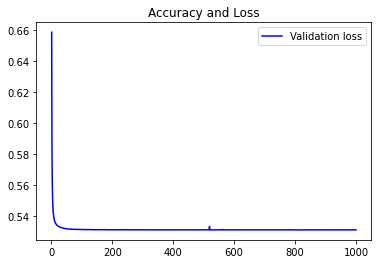

In [40]:


loss = history.history['loss']
epochs = range(1, len(loss) + 1)
 
plt.title('Accuracy and Loss')

plt.plot(epochs, loss, 'blue', label='Validation loss')
plt.legend()
plt.show()

In [78]:
testPredict.shape

(3801, 6)

In [79]:
testPredict[2000]

array([-9.4279333e-12, -1.0288640e-13,  2.0613359e-01,  2.5895984e+00,
       -2.3267719e-04, -1.4744103e-03], dtype=float32)

In [41]:
RMSE, MAE, MAPE, AMAPE = evaluate(test_Y, testPredict)
print(RMSE, MAE, MAPE, AMAPE)


21.674785005288044 2.6152200933478156 inf 3578196.7307087453


E:\Temp/ipykernel_25212/2821199893.py:52: RuntimeWarning: divide by zero encountered in double_scalars
  Score_MAPE += abs((predict[:, k][i] - real[:, k][i]) / real[:, k][i])


In [85]:
np.savetxt('trainPredict.csv', trainPredict, delimiter=',')
np.savetxt('testPredict.csv',testPredict,delimiter=',')

In [21]:
trainPredict[:,1].shape,train_Y.shape

((15203,), (15203, 6))

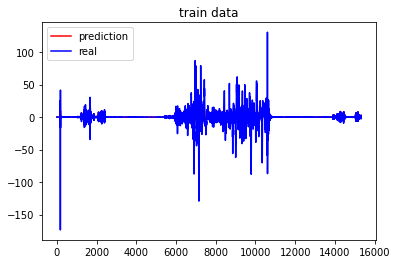

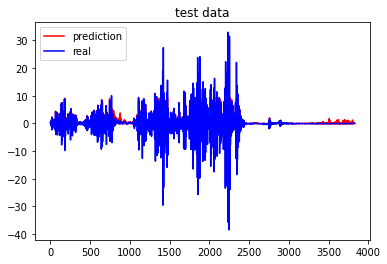

In [42]:
i=3
plt.plot(list(trainPredict[:,i]), color='red', label='prediction')
plt.plot(list(train_Y[:,i]), color='blue', label='real')
plt.legend(loc='upper left')
plt.title('train data')
plt.show()

plt.plot(list(testPredict[:,i]), color='red', label='prediction')
plt.plot(list(test_Y[:,i]), color='blue', label='real')
plt.legend(loc='upper left')
plt.title('test data')
#plt.suptitle('units==20,RMSE=\d,MAE=\d,MAPE=\d,AMAPE=\d',RMSE,MAE,MAPE,AMAPE)
plt.show()
    

In [9]:
len(test_Y)/6
testPredict.shape

(3801, 6)

In [86]:
np.savetxt('train_Y.csv',train_Y,delimiter=',')
np.savetxt('test_Y.csv',test_Y,delimiter=',')

(19004, 1200)